In [14]:
import pickle
import sys
import os
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import anndata as ad

import matplotlib.pyplot as plt
from scipy.stats import lognorm

sys.path.insert(0, '../4_preffect')
from _config import configs
from preffect_factory import factory

from _utils import ensure_directory

In [15]:
# if the dataset generated will have artificial drop-out
configs['lambda_counts'] = 0.1
configs['masking_strategy'] = None #'MCAR_2'

# set samples / genes
M=1000
N=1000

# set range of Mu and thetas
theta_select = [0.01, 0.1, 1, 2, 5, 10, 100]
mu_select = [50, 100, 500, 1000]

In [16]:
# right now, batch 2 is not created. If we want a grid with batch effects, we'll need to change this
def generate_simple_dataset(M=M, N=N, mu_1=1, theta_1=1, mu_2=1, theta_2=1):

    # Batch assignment
    # right now, program is set to only create "batch 1" patients
    batches = np.random.choice([0, 1], size=M, p=[1, 0])
    alt_cat = np.random.choice([0, 1, 2, 3], size=M, p=[0.25, 0.25, 0.25, 0.25]) # random cat variable
    alt_cont = np.random.rand(M) # random cont variable between 0-1

    # Generate mu values for each gene for each batch from log-normal
    std_dev = 0.1
    mu_batch1 = np.random.lognormal(np.log(mu_1), std_dev, size=N) # was 353

    mu_batch2 = np.random.lognormal(np.log(mu_2), std_dev, size=N)

    # Generate theta values for each gene for each batch
    theta_batch1 = np.full(N, theta_1)
    theta_batch2 = np.full(N, theta_2)

    # Function to generate gene counts
    def generate_gene_counts(mu, theta, size):
        return np.random.negative_binomial(theta, theta / (theta + mu), size=size)

    # Generate count matrix X and truth matrix
    X = np.zeros((M, N))
    truth = np.zeros((M, N))

    for i in range(M):
        if batches[i] == 0:
            X[i, :] = generate_gene_counts(mu_batch1, theta_1, N)
            truth[i, :] = mu_batch1
        else:
            X[i, :] = generate_gene_counts(mu_batch2, theta_2, N)
            truth[i, :] = mu_batch2

    adata = anndata.AnnData(X=X)

    # added a few random variables to test multiple cat/cont. variables
    adata.obs['batch'] = pd.Categorical(batches)
    adata.obs['rand_cat'] = pd.Categorical(alt_cat)
    adata.obs['rand_cont'] = pd.Categorical(alt_cont)

    gene_names = [f'gene_{i}' for i in range(N)]
    adata.var['gene'] = gene_names
    adata.var_names = gene_names

    adata.var['mu_batch1'] = mu_batch1
    adata.var['mu_batch2'] = mu_batch2
    adata.var['theta_batch1'] = theta_batch1
    adata.var['theta_batch2'] = theta_batch2
    adata.layers["truth"] = truth

    return adata


def MCAR_2(adata, Pis):

    X = adata.X.copy()  # clone X before modifying
    indices_for_all_genes = []

    for j in range(N):
        num_indices_to_zero = int(Pis[j] * M)
        indices_to_zero = random.sample(range(M), num_indices_to_zero)
        for idx in indices_to_zero:
            indices_for_all_genes.append((idx, j))
        X[indices_to_zero, j] = 0

    return X

In [ ]:
data_count = 0

for mus in mu_select:
    for thetas in theta_select:
        data_count += 1

        # Create NB distributions
        train = generate_simple_dataset(M, N, mu_1=mus, theta_1 = thetas)
        test = generate_simple_dataset(M, N, mu_1=mus, theta_1 = thetas)
        validation = generate_simple_dataset(M, N, mu_1=mus, theta_1 = thetas)

        # Add zeroes to mimick dropout (if desired)
        if configs['masking_strategy'] == 'MCAR_2':
            # we want Pis to be consistent across datasets; we should also add it to var
            Pis = np.random.rand(N) * configs['lambda_counts']
            
            train.X = MCAR_2(train, Pis)
            test.X = MCAR_2(test, Pis)
            validation.X = MCAR_2(validation, Pis)

            train.var['Pis'] = Pis
            test.var['Pis'] = Pis
            validation.var['Pis'] = Pis

        # write
        dataset_name = "dataset_grid_" + str(data_count)
        configs['input_anndata_path'] = '/path/to/output/main_synthetic/' + dataset_name + '/'
        configs['input_inference_anndata_path'] = '/path/to/output/main_synthetic/' + dataset_name + '/train/'

        ensure_directory(os.path.join(configs['input_anndata_path'], 'train'))
        ensure_directory(os.path.join(configs['input_anndata_path'], 'validation'))
        ensure_directory(os.path.join(configs['input_anndata_path'], 'test'))

        train.write(os.path.join(configs['input_anndata_path'], 'train', "syn_data_grid_" + str(data_count) + "_train.tau_1.h5ad"))
        validation.write(os.path.join(configs['input_anndata_path'], 'validation', "syn_data_grid_" + str(data_count) + "_validation.tau_1.h5ad"))
        test.write(os.path.join(configs['input_anndata_path'], 'test', "syn_data_grid_" + str(data_count) + "_test.tau_1.h5ad"))


/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


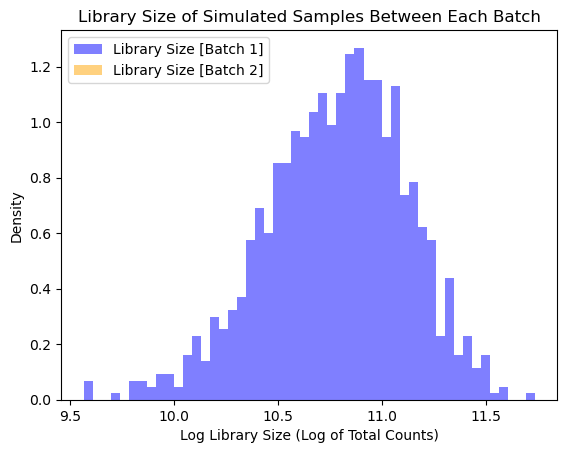

In [18]:
# John added code
# I wanted to see exactly how different the distribution of expression was between the two batches
# draw library size information distrubtions
library_sizes = np.log(train.X.sum(axis=1))

batches = train.obs['batch']
library_sizes_batch1 = library_sizes[batches == 0]
library_sizes_batch2 = library_sizes[batches == 1]

# Plotting the samples
#plt.hist(library_sizes, bins=50, density=True, alpha=0.5, color='blue', label=f'Library Size [all samples]')
#plt.figure(figsize=(8, 6))
plt.hist(library_sizes_batch1, bins=50, density=True, alpha=0.5, color='blue', label='Library Size [Batch 1]')
plt.hist(library_sizes_batch2, bins=50, density=True, alpha=0.5, color='orange', label='Library Size [Batch 2]')
plt.title('Library Size of Simulated Samples Between Each Batch')
plt.xlabel('Log Library Size (Log of Total Counts)')
plt.ylabel('Density')
plt.legend()
plt.show()

So there is a clear difference, nearly 10x more reads in the first batch

In [21]:


num_categories = len(np.unique(train.obs['batch']))  
      
subsets = [train.X[train.obs['batch'] == value] for value in train.obs['batch']]
#averages = [subset.mean(dim=0) for subset in subsets]
print(np.unique(train.obs['batch']))
print(subsets[0])
print(subsets[1])
print(subsets[2])

print(train.X.shape)

[0]
[[  0.   0.   0. ...   0.   8.   0.]
 [  0.   0.   0. ...   0.  15.   0.]
 [  0.   0.  28. ...   0.   0.   0.]
 ...
 [ 84.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ... 649.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
[[  0.   0.   0. ...   0.   8.   0.]
 [  0.   0.   0. ...   0.  15.   0.]
 [  0.   0.  28. ...   0.   0.   0.]
 ...
 [ 84.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ... 649.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
[[  0.   0.   0. ...   0.   8.   0.]
 [  0.   0.   0. ...   0.  15.   0.]
 [  0.   0.  28. ...   0.   0.   0.]
 ...
 [ 84.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ... 649.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
(1000, 1000)
